# Dask

Dask is a flexible tool enabling Python parallelization on a single machine or on a cluster. It is built on top of the standard SciPy tools (i.e., NumPy and Pandas), allowing to scale the computations to employ multiple cores or processors. This tutorial covers both the high level usage of Dask collections, as well as Dask dataframes.

## Arrays Dask

Dask provides ``dask.array``, a multidimensional array type similar to ``ndarray`` in NumPy, but employing distributed algorithms:

* __Parallel__: uses all the available cores in the computer.
* __Out-of-core__: works on blocks of the global data, breaking down the computation into subtasks that can be made to fit the available memory.

Let us perform a simple computation on a moderately-sized array (400M doubles, ~3 GB):

In [1]:
import numpy as np

In [2]:
%%time
x = np.random.normal( 10, 0.1, size=(20000, 20000) )
y = x.mean( axis=0 )
y

CPU times: user 5.17 s, sys: 158 ms, total: 5.32 s
Wall time: 5.37 s


array([ 9.9969435 , 10.00063268, 10.00053381, ..., 10.00128095,
        9.99857659,  9.99910382], shape=(20000,))

The same computation using a Dask array:

In [3]:
import dask.array as da

In [4]:
%%time
x = da.random.normal( 10, 0.1, size=(20000,20000), chunks=(1000,1000) )
y = x.mean(axis=0)
y.compute()

CPU times: user 7.78 s, sys: 183 ms, total: 7.96 s
Wall time: 477 ms


array([10.000797  , 10.00069855,  9.99900635, ...,  9.99981776,
       10.00035869,  9.99892919], shape=(20000,))

/usr/lib/python3.13/site-packages/dask/dataframe/io/csv.py:77: DtypeWarning: Columns (16,17,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/usr/lib/python3.13/site-packages/dask/dataframe/io/csv.py:77: DtypeWarning: Columns (16,17,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/usr/lib/python3.13/site-packages/dask/dataframe/io/csv.py:77: DtypeWarning: Columns (15,16,17,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/usr/lib/python3.13/site-packages/dask/dataframe/io/csv.py:77: DtypeWarning: Columns (15,16,17,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/usr/lib/python3.13/site-packages/dask/dataframe/io/csv.py:77: DtypeWarning: Columns (15,16,17,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False

The Dask version has executed in just ~1s, although it required ~12s of CPU (i.e., it has employed 12 cores simultaneously). The difference between both versions is that Dask has implicitly parallelized the computation.

Note that 12 cores were used because that was the number of cores available in the computer employed to execute this Notebook (does not necessarily match the computer employed during the class). Besides, dividing the array with 400M elements into blocks of 1M elements exposes a large amount of concurrency, allowing efficient parallelization. If we had worked with larger blocks then it might not have been possible to exploit the available concurrency:

In [5]:
%%time
x = da.random.normal( 10, 0.1, size=(20000,20000), chunks=(10000,10000) )
y2 = x.mean(axis=0)
y2.compute()

CPU times: user 5.2 s, sys: 160 ms, total: 5.36 s
Wall time: 1.37 s


array([ 9.9992754 ,  9.99949521, 10.00054621, ..., 10.00051488,
       10.00071588,  9.99994331], shape=(20000,))

As can be seen, in this case the array was split into four chunks only, preventing the use of more computational resources.

Dask provides a ``visualize()`` function which allows to plot the graph of the tasks that need to be performed and their dependences:

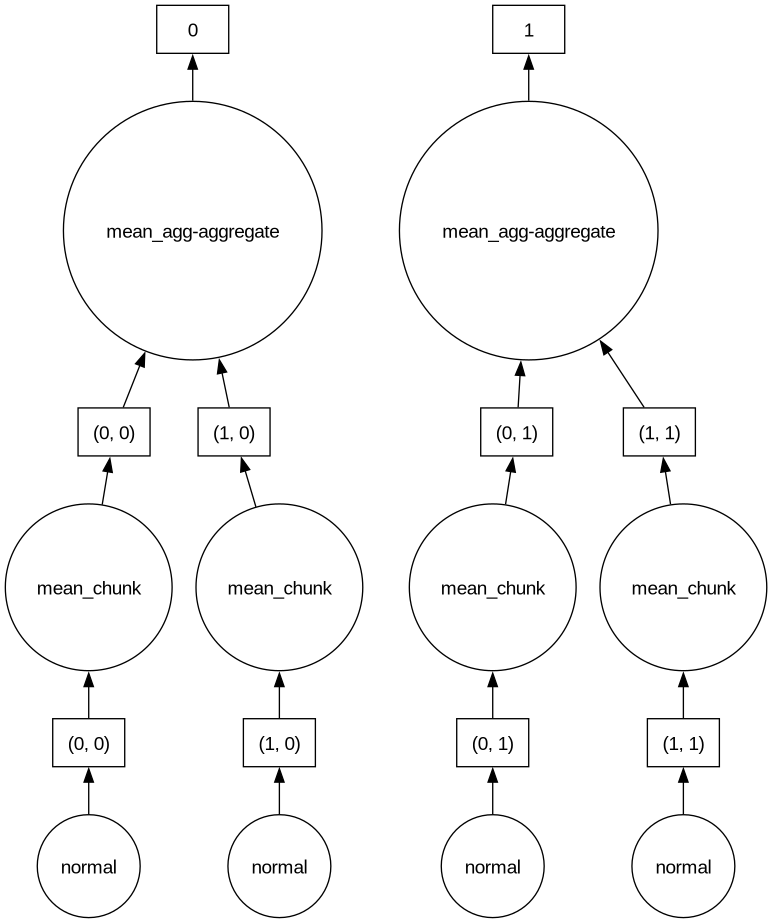

In [6]:
y2.visualize()

Although the task graph of the 400-block computation is too large to fit the screen:

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.429714 to fit


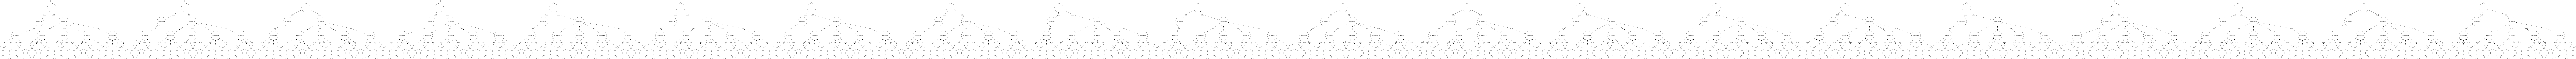

In [7]:
y.visualize()

Dask arrays do not fully implement NumPy's interface. Specifically, ``np.linalg`` is not currently fully available.

## Dask Dataframes

Dask provides a distributed implementation of Pandas ``DataFrame``, allowing to perform computations in a parallel, out-of-core fashion.

The provided interface is identical to the Pandas one:

In [8]:
import dask.dataframe as dd

iris_csv = dd.read_csv( 'Files-12/iris.csv' )
iris_csv

,sepal_length,sepal_width,petal_length,petal_width,species
npartitions=1,,,,,
,float64,float64,float64,float64,string
,...,...,...,...,...


As can be seen, a schema was created to work with the tabular data. However, this schema was not populated with data. It is a ``dask.delayed`` object, i.e., an object which represents only schemas, computations, and dependences independently from the actual data.

We can visualize the first few rows of the table using the ``head()`` function, similar to the one in Pandas:

In [9]:
iris_csv.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Like in Pandas, we can inspect the values stored in the `species` column through the `value_counts()` function:

In [10]:
iris_csv.species.value_counts()

Dask Series Structure:
npartitions=1
    int64[pyarrow]
               ...
Dask Name: valuecounts, 4 expressions
Expr=ArrowStringConversion(frame=FromMapProjectable(9331354))['species'].valuecounts(split_out=True)

As can be seen, in a Dask DataFrame the ``value_counts()`` function does not return a value, but rather specifies a computation on a particular schema (in this case, the ``iris_csv`` table). In order to compute the actual value we need to explicitly perform it by calling ``compute()``:

In [11]:
iris_csv.species.value_counts().compute()

species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64[pyarrow]

As with Pandas, Blaze provides vectorized operations on datasets, and allows to use native NumPy operations on them:

In [12]:
iris_csv.sepal_length.mean().compute()

np.float64(5.843333333333334)

In [13]:
import numpy as np
np.log(iris_csv.sepal_length).compute()

0      1.629241
1      1.589235
2      1.547563
3      1.526056
4      1.609438
         ...   
145    1.902108
146    1.840550
147    1.871802
148    1.824549
149    1.774952
Name: sepal_length, Length: 150, dtype: float64

Note that a regular operation (e.g., a NumPy function) executed on top of a ``delayed`` object (e.g., a Dask DataFrame) becomes a ``delayed`` operation which must be started using ``compute()``:

In [14]:
np.log(iris_csv.sepal_length)

Dask Series Structure:
npartitions=1
    float64
        ...
Dask Name: log, 4 expressions
Expr=UFunc(log)

### Example: Home mortgage disclosure act

Let us analyze the data from the Home Mortgage Disclosure Act, a dataset containing events and actions related to mortgages signed by a set of agencies of the US government. This dataset takes up 10 GB in a CSV file. Let us employ standard Pandas mechanisms first:

NOTE: This file is too large for github. You can download it from [this link](https://gac.udc.es/~gabriel/dahpc/hmda_lar-2012.csv.bz2).

In [15]:
import pandas as pd

%time hmda = pd.read_csv( 'Files-12/hmda_lar-2012.csv' )

<timed exec>:1: DtypeWarning: Columns (15,16,17,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 57 s, sys: 10.2 s, total: 1min 7s
Wall time: 1min 7s


In [16]:
hmda.head()

,action_taken,action_taken_name,agency_code,agency_abbr,agency_name,applicant_ethnicity,applicant_ethnicity_name,applicant_income_000s,applicant_race_1,applicant_race_2,...,state_abbr,state_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,rate_spread,tract_to_msamd_income
0,1,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,173.0,5,NaN,...,IL,Illinois,77300.0,264,2153.0,1971.0,45.820000,7894.0,NaN,170.679993
1,1,Loan originated,5,NCUA,National Credit Union Administration,2,Not Hispanic or Latino,83.0,5,NaN,...,MI,Michigan,52100.0,116,1662.0,1271.0,3.340000,4315.0,NaN,102.760002
2,6,Loan purchased by the institution,9,CFPB,Consumer Financial Protection Bureau,4,Not applicable,70.0,7,NaN,...,AR,Arkansas,58200.0,159,1194.0,708.0,21.870001,4239.0,NaN,127.639999
3,6,Loan purchased by the institution,9,CFPB,Consumer Financial Protection Bureau,2,Not Hispanic or Latino,108.0,5,NaN,...,MN,Minnesota,83900.0,100,1927.0,1871.0,13.680000,4832.0,NaN,137.669998
4,1,Loan originated,3,FDIC,Federal Deposit Insurance Corporation,2,Not Hispanic or Latino,NaN,5,NaN,...,IN,Indiana,63800.0,267,1309.0,1160.0,4.680000,3612.0,NaN,139.100006


In [17]:
%time hmda.groupby( "applicant_race_name_1" ).applicant_income_000s.mean().sort_values()

CPU times: user 544 ms, sys: 3.48 ms, total: 547 ms
Wall time: 548 ms


applicant_race_name_1
Black or African American                                                             76.296082
American Indian or Alaska Native                                                      85.283834
Native Hawaiian or Other Pacific Islander                                             98.524405
White                                                                                107.622588
Not applicable                                                                       117.691947
Information not provided by applicant in mail, Internet, or telephone application    123.897830
Asian                                                                                128.281887
Name: applicant_income_000s, dtype: float64

As can be seen, the time to read the data was high, but once these are stored in main memory coputations are relatively quick.

Next we will use a Dask DataFrame to perform the same computation:

In [18]:
%time hmda = dd.read_csv( 'Files-12/hmda_lar-2012.csv')
hmda

CPU times: user 19.5 ms, sys: 2.77 ms, total: 22.2 ms
Wall time: 21.7 ms


,action_taken,action_taken_name,agency_code,agency_abbr,agency_name,applicant_ethnicity,applicant_ethnicity_name,applicant_income_000s,applicant_race_1,applicant_race_2,applicant_race_3,applicant_race_4,applicant_race_5,applicant_race_name_1,applicant_race_name_2,applicant_race_name_3,applicant_race_name_4,applicant_race_name_5,applicant_sex,applicant_sex_name,application_date_indicator,as_of_year,census_tract_number,co_applicant_ethnicity,co_applicant_ethnicity_name,co_applicant_race_1,co_applicant_race_2,co_applicant_race_3,co_applicant_race_4,co_applicant_race_5,co_applicant_race_name_1,co_applicant_race_name_2,co_applicant_race_name_3,co_applicant_race_name_4,co_applicant_race_name_5,co_applicant_sex,co_applicant_sex_name,county_code,county_name,denial_reason_1,denial_reason_2,denial_reason_3,denial_reason_name_1,denial_reason_name_2,denial_reason_name_3,edit_status,edit_status_name,hoepa_status,hoepa_status_name,lien_status,lien_status_name,loan_purpose,loan_purpose_name,loan_type,loan_type_name,msamd,msamd_name,owner_occupancy,owner_occupancy_name,preapproval,preapproval_name,property_type,property_type_name,purchaser_type,purchaser_type_name,respondent_id,sequence_number,state_code,state_abbr,state_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,rate_spread,tract_to_msamd_income
npartitions=186,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,string,int64,string,string,int64,string,float64,int64,float64,float64,float64,float64,string,float64,float64,float64,float64,int64,string,int64,int64,float64,int64,string,int64,float64,float64,float64,float64,string,float64,float64,float64,float64,int64,string,int64,string,float64,float64,float64,float64,float64,float64,float64,string,int64,string,int64,string,int64,string,int64,string,float64,string,int64,string,int64,string,int64,string,int64,string,string,int64,int64,string,string,int64,int64,int64,int64,float64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [19]:
%time hmda.groupby( "applicant_race_name_1" ).applicant_income_000s.mean().compute()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+--------------------------------+---------+----------+
| Column                         | Found   | Expected |
+--------------------------------+---------+----------+
| applicant_race_name_2          | object  | float64  |
| applicant_race_name_3          | object  | float64  |
| applicant_race_name_4          | object  | float64  |
| applicant_race_name_5          | object  | float64  |
| co_applicant_race_name_2       | object  | float64  |
| co_applicant_race_name_3       | object  | float64  |
| co_applicant_race_name_4       | object  | float64  |
| co_applicant_race_name_5       | object  | float64  |
| county_code                    | float64 | int64    |
| denial_reason_name_1           | object  | float64  |
| denial_reason_name_2           | object  | float64  |
| denial_reason_name_3           | object  | float64  |
| hud_median_family_income       | float64 | int64    |
| number_of_1_to_4_family_units  | float64 | int64    |
| number_of_owner_occupied_units | float64 | int64    |
| population                     | float64 | int64    |
| state_code                     | float64 | int64    |
+--------------------------------+---------+----------+

The following columns also raised exceptions on conversion:

- applicant_race_name_2
  ValueError("could not convert string to float: 'White'")
- applicant_race_name_3
  ValueError("could not convert string to float: 'American Indian or Alaska Native'")
- applicant_race_name_4
  ValueError("could not convert string to float: 'Native Hawaiian or Other Pacific Islander'")
- applicant_race_name_5
  ValueError("could not convert string to float: 'White'")
- co_applicant_race_name_2
  ValueError("could not convert string to float: 'White'")
- co_applicant_race_name_3
  ValueError("could not convert string to float: 'American Indian or Alaska Native'")
- co_applicant_race_name_4
  ValueError("could not convert string to float: 'Native Hawaiian or Other Pacific Islander'")
- co_applicant_race_name_5
  ValueError("could not convert string to float: 'White'")
- denial_reason_name_1
  ValueError("could not convert string to float: 'Credit history'")
- denial_reason_name_2
  ValueError("could not convert string to float: 'Collateral'")
- denial_reason_name_3
  ValueError("could not convert string to float: 'Employment history'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'applicant_race_name_2': 'object',
       'applicant_race_name_3': 'object',
       'applicant_race_name_4': 'object',
       'applicant_race_name_5': 'object',
       'co_applicant_race_name_2': 'object',
       'co_applicant_race_name_3': 'object',
       'co_applicant_race_name_4': 'object',
       'co_applicant_race_name_5': 'object',
       'county_code': 'float64',
       'denial_reason_name_1': 'object',
       'denial_reason_name_2': 'object',
       'denial_reason_name_3': 'object',
       'hud_median_family_income': 'float64',
       'number_of_1_to_4_family_units': 'float64',
       'number_of_owner_occupied_units': 'float64',
       'population': 'float64',
       'state_code': 'float64'}

to the call to `read_csv`/`read_table`.

What happened? The ``pandas.read_csv()`` function reads a full file before inferring the data types for each column. However, ``dask.dataframe.read_csv()`` is designed to work with very large tables whose size prevents in-memory processing. As such, it reads a small fragment from the beginning of the file and tries to infer a data type for each column. Inferred data types are then employed when processing the full file.

In this example, the inferred data types are not correct. The first rows inspected by ``dask.dataframe.read_csv()`` do not contain values for several columns, and therefore a ``float``datatype is inferred. However, these columns turn out to contain character strings. The opposite problem also happens: several columns which are inferred as integer numbers with mandatory values then contain NaNs, which requires a floating point value.

The simplest solution in this case is to perform a trial-and-error process, manually assigning the data types for offending columns (the correct data type is suggested by Dask in the error message), and repeating the process until all the errors are gone:

In [20]:
%time hmda=dd.read_csv("Files-12/hmda_lar-2012.csv", dtype={'applicant_race_name_2': 'object', 'applicant_race_name_3': 'object', 'applicant_race_name_4': 'object', 'applicant_race_name_5': 'object', 'co_applicant_race_name_2': 'object', 'co_applicant_race_name_3': 'object', 'co_applicant_race_name_4': 'object', 'co_applicant_race_name_5': 'object', 'county_code': 'float64', 'denial_reason_name_1': 'object', 'denial_reason_name_2': 'object', 'denial_reason_name_3': 'object', 'hud_median_family_income': 'float64', 'number_of_1_to_4_family_units': 'float64', 'number_of_owner_occupied_units': 'float64', 'population': 'float64', 'state_code': 'float64'} )

CPU times: user 26 ms, sys: 0 ns, total: 26 ms
Wall time: 23.9 ms


We begin the computation again:

In [21]:
%time hmda.groupby( "applicant_race_name_1" ).applicant_income_000s.mean().compute().sort_values()

CPU times: user 1min 40s, sys: 14.1 s, total: 1min 54s
Wall time: 1min 1s


applicant_race_name_1
Black or African American                                                             76.296082
American Indian or Alaska Native                                                      85.283834
Native Hawaiian or Other Pacific Islander                                             98.524405
White                                                                                107.622588
Not applicable                                                                       117.691947
Information not provided by applicant in mail, Internet, or telephone application    123.897830
Asian                                                                                128.281887
Name: applicant_income_000s, dtype: float64

As can be seen, the creation of the DataFrame object in this case is very quick (only a few tenths of a second), whereas the execution of the out-of-core operation is slower, requiring almost 300x more computing time than the in-memory version employed by Pandas.